# 🌍 ESG & Financial Intelligence Platform
## AI-Powered Analysis of Corporate Reports (ESG And Annual)

**🎯 What this does:**
- Automatically processes PDF reports from Google Cloud Storage
- Uses Gemini 2.5 Pro to extract financial & ESG metrics
- Generates forecasts using Google's TimesFM 2.0 model
- Analyzes companies: Amgen, Novartis, Target

**📊 Features:**
- ✅ Automated PDF processing from Cloud Storage
- ✅ AI-powered data extraction (Financial + ESG metrics)
- ✅ Revenue forecasting with TimesFM 2.0
- ✅ Multi-company comparative analysis

---
**👆 Click "Runtime" → "Run all" to see the magic happen!**

# 🚀 Setup & Authentication

In [ ]:

print("🌟 Welcome to the ESG & Financial Intelligence Platform!")
print("🔧 Setting up environment...")

# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

# Install required packages
!pip install -q bigframes google-cloud-bigquery plotly seaborn

# Import libraries
import bigframes.pandas as bpd
from google.cloud import bigquery
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

print("✅ Authentication complete!")
print("✅ Libraries installed!")

# Intializing Parameters

In [38]:
# Replace the below with other company names from this list:
# novartis, amgen, target, bankofmontreal, lloyd, wellsfargo

company1 = "novartis"
company2 ="wellsfargo"
company3 = "lloyd"

PROJECT_ID = "intellitrend-project-dev"   # update if needed
PROJECT_LOCATION="US" # Others are EU, ASIA
CLOUD_RES_CONN = "ghack_conn" #must be all small case


DATASET_ID = "db_reports_insights_annual_esg" #Name of dataset to be created in BQ
OBJ_TABLE_ID = "all_reports_obj_table_metadata" #Objec table name. That holds the metadata of the source files in GCS
RAW_TABLE_ID="all_reports_ai_text_raw"   # the output text that gets extracted based on prmpt - using ML.GENERATE_TEXT

CURATED_TABLE_ID="all_reports_ai_text_curated" # response_text extracted from JSON output
CURATED2_TABLE_ID="all_reports_ai_text_curated2" # the output text that gets extracted based on prmpt - using AI.GENERATE (An alternate way - for comparison)

FINAL_TABLE_ID="all_reports_ai_text_final" # output metrics info from the curated table - using AI.GENERATE_TABLE

METRICS_TABLE_ID = "all_reports_metrics"  # format the output final table
FORECAST_TABLE_ID="all_reports_forecast" # forecast table from the formatted-output

QUALIFIED_CLOUD_RES_CONN = f"{PROJECT_ID}.{PROJECT_LOCATION}.{CLOUD_RES_CONN}"

QUALIFIED_OBJ_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{OBJ_TABLE_ID}"
QUALIFIED_RAW_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{RAW_TABLE_ID}"

QUALIFIED_CURATED_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED_TABLE_ID}"
QUALIFIED_CURATED2_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{CURATED2_TABLE_ID}"

QUALIFIED_METRICS_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{METRICS_TABLE_ID}"

QUALIFIED_FINAL_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FINAL_TABLE_ID}"
QUALIFIED_FORECAST_TABLE_ID= f"{PROJECT_ID}.{DATASET_ID}.{FORECAST_TABLE_ID}"

MODEL_ENDPOINT="gemini-2.5-pro"
MODEL_NAME="gemini_model_25pro"
QUALIFIED_MODEL_ID=f"{PROJECT_ID}.{DATASET_ID}.{MODEL_NAME}"

DATA_FILES_PATH="gs://report_insights"


# --- Bigframes setup ---
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# 🏗️ Project Configuration

In [ ]:

from google.colab import userdata

# Configure BigFrames
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = PROJECT_LOCATION

# Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID)

print(f"✅ Project configured: {PROJECT_ID}")
print("✅ BigFrames ready for action!")

#  Create Cloud Resource Connection

In [ ]:
!bq mk \
  --connection \
  --project_id={PROJECT_ID} \
  --connection_type=CLOUD_RESOURCE \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN}

# Fetch Service Account associated with the Cloud Res Connection

In [ ]:
SERVICE_ACCT = !bq show --format=prettyjson \
  --connection \
  --project_id={PROJECT_ID} \
  --location={PROJECT_LOCATION} \
  {CLOUD_RES_CONN} | grep "serviceAccountId" | cut -d '"' -f 4

SERVICE_ACCT_EMAIL = SERVICE_ACCT[0]  # first (and only) line
print(SERVICE_ACCT_EMAIL)

# Give the below roles to the Conn Service Account:
  * objectViewer and  
  * aiplatformUser



In [34]:
import time

# Use $SERVICE_ACCT_EMAIL so the Python variable expands in the shell
!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/storage.objectViewer" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/aiplatform.user" \
    --format=none

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/bigquery.connectionUser" \
    --format=none


!gcloud projects add-iam-policy-binding {PROJECT_ID} \
    --member="serviceAccount:$SERVICE_ACCT_EMAIL" \
    --role="roles/run.invoker" \
    --format=none


# Wait ~60 seconds for IAM updates to propagate
time.sleep(60)

Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].
Updated IAM policy for project [intellitrend-project-dev].


# Create the Gemini Model

In [ ]:
# 🤖 Step 0a: Create Gemini 2.5 Pro Model
print("🤖 Creating Gemini 2.5 Pro model...")

create_model_sql = f"""
CREATE OR REPLACE MODEL `{QUALIFIED_MODEL_ID}`
REMOTE WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (ENDPOINT = '{MODEL_ENDPOINT}');
"""

try:
    job = client.query(create_model_sql)
    job.result()
    print("🎉 Gemini 2.5 Pro model created successfully!")
except Exception as e:
    print(f"⚠️  Model creation issue: {e}")

# 📁 Create Object Table for PDF Reports

In [29]:


print(f"📁 Creating external table(Object Table): '{OBJ_TABLE_ID}' for PDF reports...")

create_external_table_sql = f"""
CREATE OR REPLACE EXTERNAL TABLE `{QUALIFIED_OBJ_TABLE_ID}`
WITH CONNECTION `{QUALIFIED_CLOUD_RES_CONN}`
OPTIONS (
  object_metadata = 'SIMPLE',
  uris = ['{DATA_FILES_PATH}/*']
);
"""

try:
    job = client.query(create_external_table_sql)
    job.result()
    print("✅ External table created successfully!")

    # Check what files we have
    check_files_sql = f"SELECT uri, size FROM `{QUALIFIED_OBJ_TABLE_ID}`  "
    files_df = bpd.read_gbq(check_files_sql)
    print(f"📄 Found {len(files_df)} files in storage")
    print("Sample files:")
    print(files_df.head())

except Exception as e:
    print(f"⚠️  Note: {e}")
    print("   Make sure your GCS bucket and connection are set up correctly")

📁 Creating external table(Object Table): 'all_reports_obj_table_metadata' for PDF reports...
✅ External table created successfully!
📄 Found 129 files in storage
Sample files:


                                                 uri      size
0  gs://report_insights/amgen/amgen_annualreport_...  12663856
1  gs://report_insights/amgen/amgen_annualreport_...   3651904
2  gs://report_insights/amgen/amgen_annualreport_...   3777808
3  gs://report_insights/amgen/amgen_annualreport_...  12725236
4  gs://report_insights/amgen/amgen_annualreport_...   8154936

[5 rows x 2 columns]


#  🧠 Extract Financial & ESG Data - Using ML.GENERATE_TEXT

In [30]:

print(f"🧠 Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

generate_text_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_RAW_TABLE_ID}` AS (
SELECT
  *
FROM
  ML.GENERATE_TEXT(
    MODEL `{QUALIFIED_MODEL_ID}`,
    TABLE `{QUALIFIED_OBJ_TABLE_ID}`,
    STRUCT(
      '''
You are an expert ESG and Financial analyst. Use only the information provided in the document to answer.
        Fetch Financial and Sustainability Details including tabular and image data for each PDF.
        Read the filename. If it is a sustainability report, please get only ESG details. If it is an annual report, get just the financials as below.
        Ensure you fetch details so it has answers for the below:
        Financial Performance
        What is the total revenue this year?
        How has revenue changed compared to last year?
        What is the net profit or loss?
        How have the earnings per share (EPS) changed?
        Are gross margins improving or declining?
        Are operating margins stable or volatile?
        How has net margin shifted year over year?
        Is cash flow from operations positive and consistent?
        How much free cash flow is available?
        How are working capital levels trending?
        Balance Sheet & Liquidity
        What is the total debt level?
        Is the debt-to-equity ratio rising or falling?
        Does the company have enough liquidity to cover short-term liabilities?
        What is the current ratio and quick ratio?
        How much cash and equivalents are available?
        Are interest expenses sustainable?
        How sensitive is the company to interest rate changes?
        What is the level of contingent liabilities?
        Business Strategy
        What are the company’s core growth initiatives?
        Is management investing in new markets or products?
        How much is spent on research and development (R&D)?
        Are acquisitions or divestitures planned?
        Is the company expanding geographically?
        What is the company’s competitive advantage?
        Is the advantage sustainable against competitors?
        Is digital transformation a core part of the strategy?
        Risk Factors
        What macroeconomic risks affect the business?
        What industry-specific risks are highlighted?
        What operational risks are disclosed?
        Are supply chain risks material?
        Are legal or regulatory risks mentioned?
        How is foreign exchange risk managed?
        How dependent is revenue on a few customers?
        Are raw material price risks significant?
        Governance & Leadership
        Is the board majority independent?
        How many women or minorities are on the board?
        Is executive compensation performance-linked?
        Does management own significant equity?
        Are shareholder rights well protected?
        Is succession planning disclosed?
        Has management delivered on past promises?
        Is the auditor independent and credible?
        Shareholder Value
        Is the company paying dividends?
        Is the dividend payout sustainable?
        Is the dividend policy clear?
        Are share buybacks taking place?
        Is return on equity (ROE) improving?
        Is return on assets (ROA) stable?
        Has shareholder equity grown consistently?
        What is the earnings guidance for next year?
        Investor Questions – Sustainability Reports
        Environmental
        What is the total Scope 1 emissions?
        What is the total Scope 2 emissions?
        What is the total Scope 3 emissions?
        Are science-based targets disclosed?
        Has the company committed to net-zero?
        What percentage of energy is renewable?
        Is energy efficiency improving year over year?
        What is the total water withdrawal?
        What is water recycled or reused?
        Is the company exposed to water stress?
        How much total waste is generated?
        How much waste is recycled or diverted from landfill?
        Are hazardous waste levels disclosed?
        How sustainable are raw material sourcing practices?
        Are biodiversity risks addressed?
        Social
        What is the total workforce size?
        What percentage of employees are women?
        What percentage of leadership roles are held by women?
        What is minority representation in the workforce?
        What is the employee turnover rate?
        How many workplace injuries occurred?
        What is the lost-time injury frequency rate?
        Are labor rights respected across the supply chain?
        Is child labor risk disclosed in supply chains?
        Are employee training hours increasing per year?
        Are wages above local living wage levels?
        Is there employee engagement survey data?
        What community development initiatives exist?
        What philanthropic contributions were made?
        Is there disclosure on data privacy and cybersecurity?
        Governance (ESG-specific)
        Is there a dedicated board ESG committee?
        How often does the board review ESG matters?
        Is ESG risk included in enterprise risk management?
        Is executive compensation tied to ESG goals?
        Are ESG targets linked to management incentives?
        Is ESG performance externally assured?
        Are ESG disclosures aligned with GRI or SASB?
        Does the company report under TCFD or ISSB?
        Is CDP reporting publicly available?
        Are stakeholder engagement practices disclosed?
        Risk & Opportunity
        What are the identified physical climate risks?
        What are the identified transition risks?
        Is there disclosure on carbon pricing exposure?
        How dependent is revenue on carbon-intensive activities?
        What sustainability-linked opportunities are identified?
        Are green products or services generating revenue?
        Is access to sustainable finance increasing?
        Are suppliers evaluated for ESG performance?
        Are ESG clauses included in supplier contracts?
        Is there disclosure on product lifecycle impacts?
      ''' AS prompt,

      0 AS temperature,
      8092 AS max_output_tokens
    )
  )
WHERE uri like '%{company1}%' or uri like '%{company2}%' or  uri like '%{company3}%'
);
"""
print("\n\n the SQL \n\n", generate_text_sql)
try:
    print("⏳ Processing... This may take 2-3 minutes")
    job = client.query(generate_text_sql)
    job.result()

    # Check results
    check_sql = f"SELECT COUNT(*) as processed_files FROM `{QUALIFIED_RAW_TABLE_ID}`"
    result = client.query(check_sql).result()
    count = list(result)[0][0]
    print(f"✅ Successfully processed {count} files!")

except Exception as e:
    print(f"⚠️  Processing issue: {e}")

🧠 Processing PDFs with gemini_model_25pro...
This analyzes novartis, wellsfargo, and lloyd reports...


 the SQL 

 
CREATE OR REPLACE TABLE `intellitrend-project-dev.db_reports_insights_annual_esg.all_reports_ai_text_raw` AS (
SELECT
  *
FROM
  ML.GENERATE_TEXT(
    MODEL `intellitrend-project-dev.db_reports_insights_annual_esg.gemini_model_25pro`,
    TABLE `intellitrend-project-dev.db_reports_insights_annual_esg.all_reports_obj_table_metadata`,
    STRUCT(
      '''
You are an expert ESG and Financial analyst. Use only the information provided in the document to answer.
        Fetch Financial and Sustainability Details including tabular and image data for each PDF.
        Read the filename. If it is a sustainability report, please get only ESG details. If it is an annual report, get just the financials as below.
        Ensure you fetch details so it has answers for the below:
        Financial Performance
        What is the total revenue this year?
        How has revenue change

### Alternate Method to ML.GENERATE_TEXT:
# Extract Financial & ESG Data - using AI.GENERATE

In [ ]:

print(f"🧠 Processing PDFs with {MODEL_NAME}...")
print(f"This analyzes {company1}, {company2}, and {company3} reports...")

generate_text_sql2 = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_CURATED2_TABLE_ID}` AS
SELECT
  uri,
  AI.GENERATE(
    CONCAT(
      "You are an expert ESG and Financial analyst. Use only the information provided in the document to answer.\\n",
      "Fetch Financial and Sustainability Details including tabular and image data for each PDF.\\n",
      "Open and Read the PDF: ",
      JSON_VALUE(
        OBJ.GET_ACCESS_URL(
          OBJ.MAKE_REF(uri, '{QUALIFIED_CLOUD_RES_CONN}'),
          'r'
        ),
        '$.access_urls.read_url'
      )
    ),
    connection_id => '{QUALIFIED_CLOUD_RES_CONN}',
    endpoint => '{MODEL_ENDPOINT}',
    output_schema => 'uri STRING, response_text STRING'
  ).response_text AS response_text
FROM `{QUALIFIED_OBJ_TABLE_ID}`
WHERE uri LIKE '%{company1}%' OR uri LIKE '%{company2}%' OR uri LIKE '%{company3}%';
"""

try:
    print("⏳ Processing... This may take 2-3 minutes")
    job = client.query(generate_text_sql2)
    job.result()

    # Check results
    check_sql = f"SELECT COUNT(*) as processed_files FROM `{QUALIFIED_CURATED2_TABLE_ID}`"
    result = client.query(check_sql).result()
    count = list(result)[0][0]
    print(f"✅ Successfully processed {count} files!")

except Exception as e:
    print(f"⚠️  Processing issue: {e}")


# 🧹 Extract Clean Text Response

In [31]:

print("🧹 Cleaning and extracting response text...")

curate_results_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_CURATED_TABLE_ID}` AS
SELECT *,
  ARRAY_TO_STRING(
    ARRAY(
      SELECT JSON_VALUE(part, '$.text')
      FROM UNNEST(JSON_QUERY_ARRAY(
        JSON_QUERY(ml_generate_text_result, '$.candidates[0].content.parts')
      )) AS part
    ),
    ''
  ) AS response_text
FROM
  `{QUALIFIED_RAW_TABLE_ID}`;
"""

try:
    job = client.query(curate_results_sql)
    job.result()
    print("✅ Response text extracted and cleaned!")

    # Show sample of extracted text
    sample_sql = f"""
    SELECT uri, LEFT(response_text, 200) as sample_text
    FROM `{QUALIFIED_CURATED_TABLE_ID}`
    LIMIT 3
    """
    sample_df = bpd.read_gbq(sample_sql)
    print("\n📝 Sample extracted text:")
    for _, row in sample_df.iterrows():
        print(f"File: {row['uri']}")
        print(f"Text: {row['sample_text']}...\n")

except Exception as e:
    print(f"⚠️  Text extraction issue: {e}")

🧹 Cleaning and extracting response text...
✅ Response text extracted and cleaned!

📝 Sample extracted text:
File: gs://report_insights/lloyd/lloyd_annualreport_2021.pdf
Text: ...

File: gs://report_insights/lloyd/lloyd_annualreport_2023.pdf
Text: ...

File: gs://report_insights/lloyd/lloyd_sustainabilityreport_2021.pdf
Text: Based on the "Lloyd's Global Compact 2021 Report," here are the key sustainability details:

### **Environmental**

*   **What is the total Scope 1, 2, and 3 emissions?**
    The report does not provi...



# 📊 Extract Structured Financial & ESG Metrics

In [32]:

print("📊 Generating structured financial and ESG metrics...")

generate_table_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FINAL_TABLE_ID}` AS
SELECT *,
    DATE(CAST(fiscal_year AS STRING) || "-01-01") AS fiscal_year_date,
    CASE
        WHEN uri LIKE '%{company1}%' THEN '{company1}'
        WHEN uri LIKE '%{company2}%' THEN '{company2}'
        WHEN uri LIKE '%{company3}%' THEN '{company3}'
    END as company_name_formatted
FROM (
    SELECT *
    FROM AI.GENERATE_TABLE(
        MODEL `{QUALIFIED_MODEL_ID}`,
        (
            SELECT CONCAT(
                "You are an expert financial analyst and ESG/Climate analyst. Extract all financial metrics and sustainability metrics and KPIs from the provided text into structured data. ",
                "For Annual reports, focus on getting the financial metrics. And for Sustainability reports focus on getting ESG metrics. ",
                "Normalize numbers by removing commas, spaces, or symbols. ",
                "Only include actual numerical financial data. ",
                "TEXT: ",
                response_text
            ) AS prompt,
            response_text as extracted_text,
            uri AS uri
        FROM `{QUALIFIED_CURATED_TABLE_ID}`
        ),
        STRUCT(
            'uris STRING, report_type STRING, company_name STRING, fiscal_year INT64, revenue_millions FLOAT64, net_income_millions FLOAT64, total_assets_millions FLOAT64, total_liabilities_millions FLOAT64, equity_millions FLOAT64, eps_basic FLOAT64, eps_diluted FLOAT64, dividends_per_share FLOAT64, employee_count INT64, business_segments ARRAY<STRING>, total_ghg_emissions FLOAT64, scope_1_ghg_emissions FLOAT64, scope_2_ghg_emissions FLOAT64, scope_3_ghg_emissions FLOAT64, carbon_intensity FLOAT64, energy_consumption FLOAT64, renewable_energy_usage FLOAT64, water_consumption FLOAT64, waste_generated FLOAT64, waste_recycled FLOAT64, sustainable_financing FLOAT64, reporting_period STRING, page_references ARRAY<STRING>, contexts ARRAY<STRING>, verbatim_quotes ARRAY<STRING>'
            AS output_schema,
            8192 AS max_output_tokens,
            0 AS temperature
        )
    ) t
);
"""

try:
    print("⏳ Structuring data... This may take 3-4 minutes")
    job = client.query(generate_table_sql)
    job.result()
    print("✅ Structured metrics extracted successfully!")

except Exception as e:
    print(f"⚠️  Table generation issue: {e}")

📊 Generating structured financial and ESG metrics...
⏳ Structuring data... This may take 3-4 minutes
✅ Structured metrics extracted successfully!


# 🔮 Revenue Forecasting with TimesFM 2.0

In [46]:

print("🔮 Generating metrics table")

metrics_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_METRICS_TABLE_ID}` AS
SELECT * FROM
    ( SELECT
        uri, fiscal_year,
        extracted_text, company_name_formatted as company_name,
        -- Determine report_type based on URI
        CASE
            WHEN LOWER(uri) LIKE '%annual%' THEN 'Annual'
            WHEN LOWER(uri) LIKE '%sustainability%' THEN 'Sustainability'
            ELSE 'Other'
        END AS report_type,
        fiscal_year_date,
        reporting_period ,
        -- Financial metrics: keep if Annual, else 0
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN revenue_millions ELSE 0 END AS revenue_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN net_income_millions ELSE 0 END AS net_income_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_assets_millions ELSE 0 END AS total_assets_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN total_liabilities_millions ELSE 0 END AS total_liabilities_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN equity_millions ELSE 0 END AS equity_millions,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN dividends_per_share ELSE 0 END AS dividends_per_share,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_basic ELSE 0 END AS eps_basic,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN eps_diluted ELSE 0 END AS eps_diluted,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN employee_count ELSE 0 END AS employee_count,
        CASE WHEN LOWER(uri) LIKE '%annual%' THEN sustainable_financing ELSE 0 END AS sustainable_financing,

        -- Sustainability metrics: keep if Sustainability report, else 0
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN carbon_intensity ELSE 0 END AS carbon_intensity,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN energy_consumption ELSE 0 END AS energy_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN renewable_energy_usage ELSE 0 END AS renewable_energy_usage,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_1_ghg_emissions ELSE 0 END AS scope_1_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_2_ghg_emissions ELSE 0 END AS scope_2_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN scope_3_ghg_emissions ELSE 0 END AS scope_3_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN total_ghg_emissions ELSE 0 END AS total_ghg_emissions,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN water_consumption ELSE 0 END AS water_consumption,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_generated ELSE 0 END AS waste_generated,
        CASE WHEN LOWER(uri) LIKE '%sustainability%' THEN waste_recycled ELSE 0 END AS waste_recycled

     FROM `{QUALIFIED_FINAL_TABLE_ID}`
     ) t
-- WHERE report_type != 'Annual';

"""

print("⏳ fetching metrics...")
job = client.query(metrics_sql)
job.result()
print("✅ Metrics table created successfully!")

🔮 Generating metrics table
⏳ fetching metrics...
✅ Metrics table created successfully!


# Try Financial/ESG Details for pre-defined questions for selected company and fiscal_year and report type

In [57]:
from IPython.display import display, Markdown


# --- Load your BigQuery table ---
#df = bpd.read_gbq(f"{QUALIFIED_METRICS_TABLE_ID}")
metrics_sql1 = f"""
SELECT *
FROM `{QUALIFIED_METRICS_TABLE_ID}`
"""
df = bpd.read_gbq(metrics_sql1)

# --- Choose which report to display ---
company = "novartis"
year = 2024
rtype = "Sustainability"   # "Annual" or "Sustainability Report"

# --- Filter ---
filtered = df[
    (df["company_name"] == company)
    & (df["fiscal_year"] == year)
    & (df["report_type"] == rtype)
]

# --- Display pretty ---
if not filtered.empty:
    text = filtered["extracted_text"].iloc[0]
    display(Markdown(text))
else:
    print("No report found for that selection.")


# --- Grab the first row (or loop if multiple) ---
text = df["extracted_text"].iloc[0]

# --- Pretty display in Colab ---
print("\n\n===========================================================================\n\n")
display(Markdown(text))

Based on the Novartis in Society Integrated Report 2024, here are the detailed financial and sustainability insights.

### **Financial Performance**

*   **What is the total revenue this year?**
    Total revenue (Net sales from continuing operations) for 2024 was **USD 50.317 billion** (p. 19).

*   **How has revenue changed compared to last year?**
    Revenue increased by **11% in USD** (12% in constant currencies) from USD 45.440 billion in 2023 (p. 19).

*   **What is the net profit or loss?**
    Net income from continuing operations was **USD 11.939 billion** in 2024, an increase of 39% (45% in constant currencies) from the prior year (p. 19).

*   **How have the earnings per share (EPS) changed?**
    Core basic earnings per share (EPS) from continuing operations increased by **21% in USD** (24% in constant currencies) to USD 7.81 in 2024, up from USD 6.47 in 2023 (p. 19).

*   **Are gross margins improving or declining?**
    The report does not provide a gross margin figure.

*   **Are operating margins stable or volatile?**
    The core operating income margin is improving, increasing to **38.7%** of net sales in 2024 from 36.0% in 2023 (p. 19).

*   **How has net margin shifted year over year?**
    The net income margin (from continuing operations) improved to **23.7%** in 2024 (calculated as $11.939B / $50.317B), up from 18.9% in 2023 (calculated as $8.572B / $45.440B) (p. 19).

*   **Is cash flow from operations positive and consistent?**
    Yes. Free cash flow from continuing operations was **USD 16.253 billion** in 2024, up 24% from USD 13.160 billion in 2023 (p. 19).

*   **How much free cash flow is available?**
    **USD 16.253 billion** from continuing operations in 2024 (p. 19).

*   **How are working capital levels trending?**
    This information is not available in the provided document.

### **Balance Sheet & Liquidity**

Information regarding total debt, debt-to-equity ratio, current/quick ratios, and contingent liabilities is not available in this integrated report. The document refers to the full Annual Report / Form 20-F for more detailed financial information.

*   **How much cash and equivalents are available?**
    This information is not available in the provided document.

### **Business Strategy**

*   **What are the company’s core growth initiatives?**
    The company's strategy is to "Deliver high-value medicines to accelerate growth," driven by momentum in its existing portfolio (including *Entresto*, *Cosentyx*, *Kisqali*) and key upcoming launches (p. 13).

*   **Is management investing in new markets or products?**
    Yes, Novartis focuses on four core therapeutic areas (cardiovascular, renal and metabolic; immunology; neuroscience; oncology) and five technology platforms (chemistry, biotherapeutics, radioligand therapy, xRNA, gene and cell therapy) (p. 13).

*   **How much is spent on research and development (R&D)?**
    In 2024, the core R&D expense from continuing operations was **USD 9.3 billion** (p. 15).

*   **Are acquisitions or divestitures planned?**
    The company has a history of strategic acquisitions and divestments to focus on its core pharmaceutical business. The Board reviewed strategic considerations around M&A in 2024, including the acquisition of Mariana Oncology and MorphoSys (p. 4, 48).

*   **Is the company expanding geographically?**
    The company focuses on priority markets: US, Germany, China, and Japan, which account for most of the expected growth in global healthcare spending. It also maintains a strong presence in other markets worldwide (p. 13).

*   **What is the company’s competitive advantage?**
    The company's advantage lies in its focus on innovation within key therapeutic areas and advanced technology platforms, a robust R&D pipeline, and a strategy to build depth and scientific expertise (p. 13).

*   **Is the advantage sustainable against competitors?**
    The company aims for sustainability by concentrating resources on priority programs, effective life-cycle management for key brands, and collaborating with external researchers and biotech companies to discover new medicines (p. 13).

*   **Is digital transformation a core part of the strategy?**
    Yes. "Scale data science and technology" is a foundational pillar of the strategy. The company is increasingly integrating artificial intelligence (AI) and data science in R&D to accelerate drug design and in business operations to enhance productivity (p. 5, 13, 21).

### **Risk Factors**

*   **What macroeconomic risks affect the business?**
    The company is affected by geopolitical and economic volatility, aging populations, and lifestyle changes that put pressure on healthcare systems (p. 4, 12).

*   **What industry-specific risks are highlighted?**
    Key industry risks include pricing and reimbursement pressure, evolving legislation (e.g., US Inflation Reduction Act), and the need to competitively discover and develop high-value medicines (p. 12, 53, 54).

*   **What operational risks are disclosed?**
    Operational risks include cybersecurity and data protection, talent management, failure to implement strategic technology programs, legal and compliance challenges, manufacturing and product quality issues, and supply chain disruptions (p. 53, 55).

*   **Are supply chain risks material?**
    Yes, supply chain continuity is listed as a key operational risk. The company works to withstand potential disruptions and improve resilience (p. 4, 53, 55).

*   **Are legal or regulatory risks mentioned?**
    Yes, "Legal, regulatory, ethics and compliance" is a key operational risk, citing challenges from evolving regulations and societal expectations (p. 53, 55).

*   **How is foreign exchange risk managed?**
    The company reports financial results in both USD and constant currencies (cc) "to remove the impact of exchange rate movements" (p. 19).

*   **How dependent is revenue on a few customers?**
    This information is not available in the provided document.

*   **Are raw material price risks significant?**
    The risk is mentioned in the context of supply chain resilience, as many products "require highly specialized raw materials" (p. 15).

### **Governance & Leadership**

*   **Is the board majority independent?**
    Yes, "All Board members are independent and nonexecutive" (p. 48).

*   **How many women or minorities are on the board?**
    Of the 13 board members pictured, **4 are women (31%)**. Minority representation is not specified (p. 51).

*   **Is executive compensation performance-linked?**
    Yes, compensation is heavily performance-linked. For the CEO in 2024, 88.5% of total realized compensation was variable. It is tied to short-term financial and strategic goals (including ESG) and long-term value creation metrics like sales growth, operating income growth, innovation, and relative total shareholder return (p. 56-58).

*   **Does management own significant equity?**
    The report mentions an Employee Share Purchase Plan (ESPP) and that a portion of executive incentive pay is in equity, but specific ownership levels are not disclosed (p. 36, 57).

*   **Are shareholder rights well protected?**
    Shareholder rights are guaranteed under Swiss law and the company's Articles of Incorporation. All shares have equal voting rights and dividend entitlement (p. 49).

*   **Is succession planning disclosed?**
    Yes, the Board discussed longer-term succession planning in 2024, including the nomination of a new Board Chair for 2025 (p. 4, 48).

*   **Has management delivered on past promises?**
    The report highlights strong 2024 performance, with double-digit growth and two guidance upgrades for net sales, indicating delivery on financial promises (p. 4, 56).

*   **Is the auditor independent and credible?**
    The external auditor's role is described on page 48. KPMG AG provided the independent assurance report on sustainability information (p. 72-73).

### **Shareholder Value**

*   **Is the company paying dividends?**
    Yes. A dividend of **CHF 3.50** per share is proposed for 2024, a 6% increase from the prior year (p. 4, 19).

*   **Is the dividend payout sustainable?**
    The report highlights strong free cash flow (USD 16.3 billion), suggesting the dividend is sustainable, but a payout ratio is not provided (p. 19).

*   **Is the dividend policy clear?**
    While a formal policy is not stated, the company notes a consistent history of dividend increases (p. 4).

*   **Are share buybacks taking place?**
    This information is not available in the provided document.

*   **Is return on equity (ROE) improving?**
    This information is not available in the provided document.

*   **Is return on assets (ROA) stable?**
    This information is not available in the provided document.

*   **Has shareholder equity grown consistently?**
    This information is not available in the provided document.

*   **What is the earnings guidance for next year?**
    The company provides a longer-term outlook: "sales growth average at least 5% annually over the five years to 2029, and reach 40% core operating income margin by 2027" (p. 5).

---
### **Sustainability (ESG) Performance**

### **Environmental**

*   **What is the total Scope 1, 2, and 3 emissions?** (p. 61)
    *   Scope 1: **207.0** thousand tCO₂e
    *   Scope 2 (market-based): **30.0** thousand tCO₂e
    *   Scope 3: **4,350.3** thousand tCO₂e

*   **Are science-based targets disclosed?**
    Yes, Novartis has near- and long-term ambitions approved by the Science Based Targets initiative (SBTi) (p. 25, 28).

*   **Has the company committed to net-zero?**
    Yes, the company has a target to achieve net-zero GHG emissions by **2040** (p. 25, 26).

*   **What percentage of energy is renewable?**
    In 2024, **96%** of purchased electricity consumption was renewable (p. 27).

*   **Is energy efficiency improving year over year?**
    Total energy use (on-site and purchased) decreased from 6.8 million GJ in 2022 to **5.8 million GJ** in 2024, indicating improved efficiency (p. 28, 61).

*   **What is the total water withdrawal?**
    **33.3 million m³** in 2024 (p. 33, 61).

*   **What is water recycled or reused?**
    The report mentions using more recycled water as a strategy but does not quantify the amount (p. 31).

*   **Is the company exposed to water stress?**
    Yes, the company identifies sites in water-stressed basins and plans to implement water use reduction targets for them. A physical risk analysis identified manufacturing sites in Pakistan, Belgium, Netherlands, Indonesia, and China as having high or very high risk for water stress (p. 31, 65).

*   **How much total waste is generated?**
    **31,100 tonnes** in 2024 (p. 33, 61).

*   **How much waste is recycled or diverted from landfill?**
    **15,600 tonnes** were recycled in 2024 (p. 33, 61).

*   **Are hazardous waste levels disclosed?**
    Yes. In 2024, 4,200 tonnes of hazardous waste were recycled and 10,600 tonnes were not recycled (p. 61).

*   **How sustainable are raw material sourcing practices?**
    The company is implementing a sustainable sourcing program and conducting nature assessments for raw material use (p. 33).

*   **Are biodiversity risks addressed?**
    Yes, the company conducted a nature assessment aligned with the TNFD LEAP approach to understand impacts on biodiversity, water, and waste (p. 31).

### **Social**

*   **What is the total workforce size?**
    **78,310** employees (headcount) at the end of 2024 (p. 10, 36, 60).

*   **What percentage of employees are women?**
    **52%** of the overall headcount are women (p. 36, 60).

*   **What percentage of leadership roles are held by women?**
    Women hold **48%** of overall management roles and **39%** of top management roles (p. 35, 36, 60).

*   **What is minority representation in the workforce?**
    This information is not available in the provided document.

*   **What is the employee turnover rate?**
    **12%** in 2024 (down from 17% in 2023) (p. 36, 60).

*   **What is the lost-time injury frequency rate?**
    The lost-time injury and illness rate for Novartis employees was **0.13** per 200,000 hours worked in 2024 (p. 36, 60).

*   **Are labor rights respected across the supply chain?**
    Yes, this is a key part of the company's human rights and supply chain management policies. The Third Party Code includes provisions for labor rights, and suppliers are assessed against them (p. 37, 46).

*   **Is child labor risk disclosed in supply chains?**
    Yes, the company acknowledges this risk and publishes a separate report on due diligence for child labor (p. 3, 37).

*   **Are employee training hours increasing per year?**
    The annual average was **39 hours per employee** in 2024, a slight increase from 38 in 2023 (p. 36, 60).

*   **Are wages above local living wage levels?**
    Yes, the company is "committed to paying employees a living wage that meets or exceeds the amount for basic living needs" (p. 36).

*   **Is there employee engagement survey data?**
    Yes, the company measures employee engagement every quarter through a voluntary, anonymous survey and maintains a Wellbeing Index (p. 34).

*   **What community development initiatives exist?**
    The report focuses on access to medicines and health system strengthening as its primary societal contribution (p. 17, 40).

*   **What philanthropic contributions were made?**
    Political contributions are disclosed (**USD 1.222 million** globally), but broader philanthropic contributions are not quantified (p. 45, 62).

*   **Is there disclosure on data privacy and cybersecurity?**
    Yes, this is addressed as a key operational risk and a governance priority, with a dedicated cybersecurity risk management program (p. 44, 53, 55).

### **Governance (ESG-specific)**

*   **Is there a dedicated board ESG committee?**
    Yes, the **Governance, Sustainability and Nomination Committee (GSNC)** holds primary responsibility for the oversight of the ESG strategy (p. 49).

*   **How often does the board review ESG matters?**
    The GSNC regularly advises the Board on ESG matters. At the management level, the ECN-level ESG Committee, chaired by the CEO, meets every two months (p. 49, 50).

*   **Is ESG risk included in enterprise risk management?**
    Yes. "Environmental, social and governance matters" is a defined strategic risk in the ERM framework (p. 53).

*   **Is executive compensation tied to ESG goals?**
    Yes. Performance against ESG-related targets is integrated into the Executive Committee's compensation as one of four strategic objectives that account for 40% of the Annual Incentive (p. 25, 57).

*   **Is ESG performance externally assured?**
    Yes, selected sustainability information is provided with limited assurance by **KPMG AG** (p. 3, 72-73).

*   **Are ESG disclosures aligned with GRI or SASB?**
    Yes, the report is prepared with reference to the **Global Reporting Initiative (GRI) standards**. A detailed GRI content index is on pages 69-71.

*   **Does the company report under TCFD or ISSB?**
    Yes, the report is prepared in accordance with the recommendations of the **Task Force on Climate-related Financial Disclosures (TCFD)**. A TCFD index is on page 64.

*   **Is CDP reporting publicly available?**
    This is not mentioned in the document.

*   **Are stakeholder engagement practices disclosed?**
    Yes, a detailed overview of stakeholder engagement, including groups, purpose, means of engagement, and issues discussed, is provided on page 17.

### **Risk & Opportunity (ESG)**

*   **What are the identified physical climate risks?**
    Physical risks identified include chronic risks (water stress, heat stress) and acute risks (cyclones, flooding, drought). A detailed scenario analysis was conducted for operations and the supply chain (p. 29-30, 65-66).

*   **What are the identified transition risks?**
    Transition risks identified include carbon pricing (direct and indirect), carbon certificate pricing, and litigation risk. Opportunities include lower electricity costs from renewables (p. 27, 67).

*   **Is there disclosure on carbon pricing exposure?**
    Yes, the company quantifies its potential financial exposure to carbon pricing under different scenarios, estimating an impact of **USD 70-184 million** in operating expenditure for 2024-2030 (p. 27, 67).

*   **How dependent is revenue on carbon-intensive activities?**
    The report analyzes how climate change could alter disease patterns and thus affect demand and sales for its products, but does not quantify revenue dependency on carbon-intensive activities directly (p. 29, 68).

*   **What sustainability-linked opportunities are identified?**
    Opportunities include potential savings in electricity costs from switching to renewables (**USD 133-228 million** from 2024-2030) and potential sales increases for medicines treating climate-exacerbated diseases like renal conditions (p. 27, 29, 68).

*   **Are green products or services generating revenue?**
    This is not quantified in the report.

*   **Is access to sustainable finance increasing?**
    The report mentions performance on sustainability-linked bond targets is published on its website, but provides no further details (p. 3).

*   **Are suppliers evaluated for ESG performance?**
    Yes, Novartis has embedded environmental and social criteria into its procurement processes and supplier contracts (p. 28, 46).

*   **Are ESG clauses included in supplier contracts?**
    Yes. In 2024, **76%** of supplier emissions were covered by contracts that include environmental criteria, with a goal of 100% by 2025 (p. 28).

*   **Is there disclosure on product lifecycle impacts?**
    Yes, the company systematically integrates life-cycle assessment (LCA) methods in its R&D pipeline to improve the environmental impact of its products (p. 26).

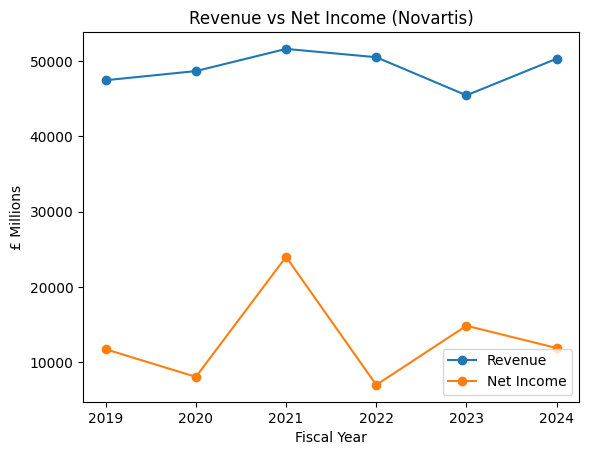

In [60]:
df_company = df[
    (df["company_name"].str.lower() == "novartis") &
    (df["report_type"].str.lower() == "annual")
]
df_company = df_company.sort_values("fiscal_year")

plt.plot(df_company["fiscal_year"], df_company["revenue_millions"], marker="o", label="Revenue")
plt.plot(df_company["fiscal_year"], df_company["net_income_millions"], marker="o", label="Net Income")
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Revenue vs Net Income (Novartis)")
plt.legend()
plt.show()

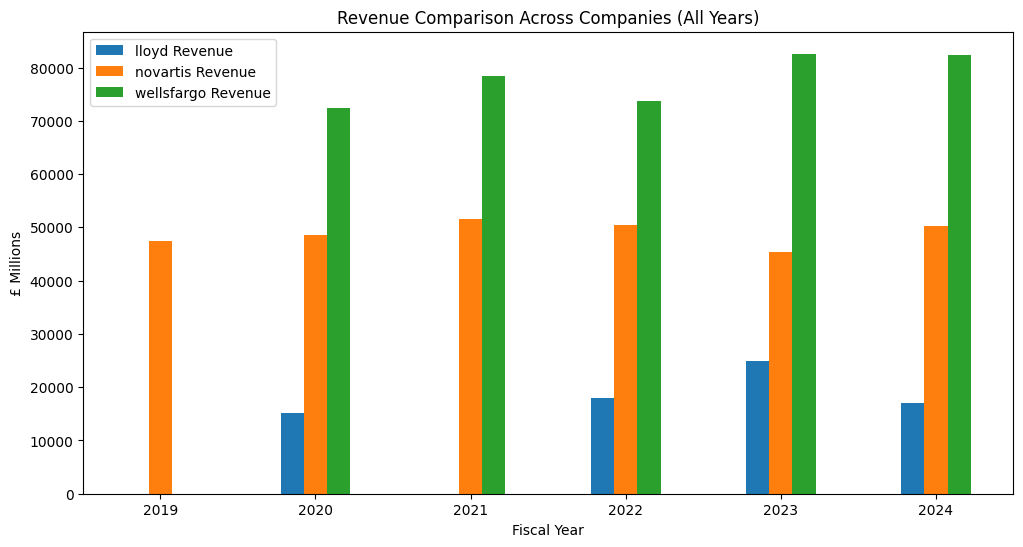

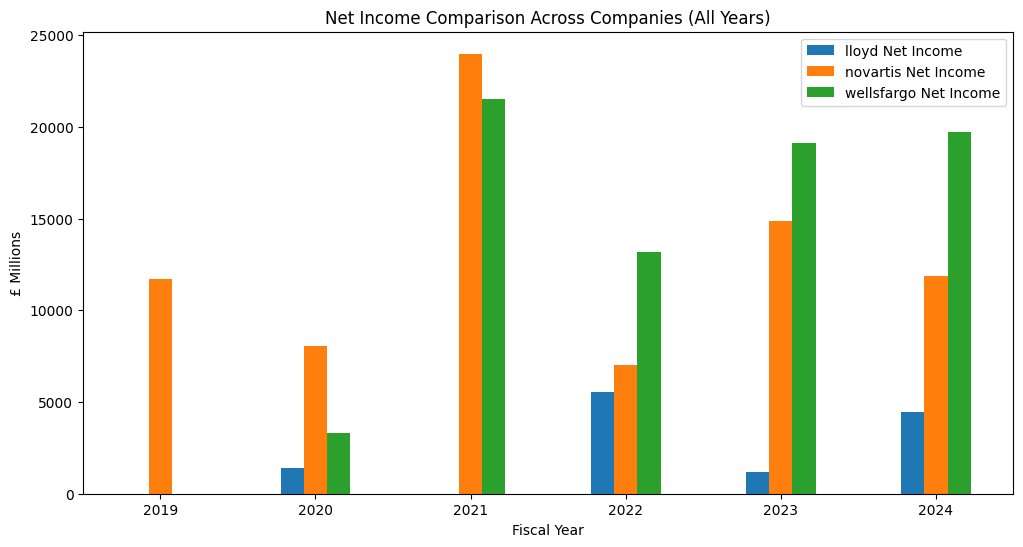

In [64]:

import numpy as np

# Filter only annual reports
df_filtered = df[df["report_type"].str.lower() == "annual"]

# Group by company and year
df_grouped = df_filtered.groupby(["company_name", "fiscal_year"])[
    ["revenue_millions", "net_income_millions"]
].sum().reset_index()

# Get unique values
companies = df_grouped["company_name"].unique().tolist()
years = sorted(df_grouped["fiscal_year"].unique())

# Set bar width
bar_width = 0.15
x = np.arange(len(years))  # positions for fiscal years

plt.figure(figsize=(12,6))

# Plot each company’s bars
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    revenues = [company_data[company_data["fiscal_year"] == y]["revenue_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, revenues, width=bar_width, label=f"{company} Revenue")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)  # Center ticks
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Revenue Comparison Across Companies (All Years)")
plt.legend()
plt.show()

# Repeat for Net Income
plt.figure(figsize=(12,6))
for i, company in enumerate(companies):
    company_data = df_grouped[df_grouped["company_name"] == company]
    net_incomes = [company_data[company_data["fiscal_year"] == y]["net_income_millions"].sum() for y in years]
    plt.bar(x + i*bar_width, net_incomes, width=bar_width, label=f"{company} Net Income")

plt.xticks(x + bar_width*(len(companies)-1)/2, years)
plt.xlabel("Fiscal Year")
plt.ylabel("£ Millions")
plt.title("Net Income Comparison Across Companies (All Years)")
plt.legend()
plt.show()


In [44]:

print("🔮 Generating revenue forecasts with TimesFM 2.0...")

forecast_sql = f"""
CREATE OR REPLACE TABLE `{QUALIFIED_FORECAST_TABLE_ID}` AS
SELECT
  *
FROM
  AI.FORECAST(
    TABLE `{QUALIFIED_METRICS_TABLE_ID}`,
    data_col => 'revenue_millions',
    timestamp_col => 'fiscal_year_date',
    model => 'TimesFM 2.0',
    id_cols => ['company_name'],
    horizon => 5,
    confidence_level => .95
  )
"""

print("⏳ Forecasting...")
job = client.query(forecast_sql)
job.result()
print("✅ Forecast table created successfully!")

🔮 Generating revenue forecasts with TimesFM 2.0...
⏳ Forecasting...
✅ Forecast table created successfully!


In [ ]:
# import requests
# from google.cloud import bigquery

# PROJECT_ID = "intellitrend-project-dev"   # update if needed
# DATASET_ID = "db_reports_insights_annual_esg"
# TABLE_ID = "all_reports_annual_esg"

# # Step 0: Fetch file list from GitHub
# url = "https://api.github.com/repos/intellitrend-global/google_hackathon_bq_ai/contents/annual_esg_reports"
# response = requests.get(url)
# files = response.json()

# pdf_files = [(f["name"], f["download_url"]) for f in files if f["name"].endswith(".pdf")]

# print("📄 Found PDF files on GitHub:")
# for name, link in pdf_files:
#     print(f"   {name} -> {link}")

# # Step 1: Initialize BigQuery client
# client = bigquery.Client(project=PROJECT_ID)

# # Step 2: Ensure dataset exists (create if not)
# dataset_ref = bigquery.DatasetReference(PROJECT_ID, DATASET_ID)
# try:
#     client.get_dataset(dataset_ref)  # Check if it exists
#     print(f"✅ Dataset {DATASET_ID} already exists")
# except Exception:
#     dataset = bigquery.Dataset(dataset_ref)
#     dataset.location = "US"
#     client.create_dataset(dataset, timeout=30)
#     print(f"📦 Created dataset {DATASET_ID}")

# # Step 3: Define schema
# schema = [
#     bigquery.SchemaField("filename", "STRING"),
#     bigquery.SchemaField("uri", "STRING"),
# ]

# # Step 4: Prepare rows
# rows = [{"filename": name, "uri": link} for name, link in pdf_files]

# # Step 5: Load into BigQuery
# job_config = bigquery.LoadJobConfig(schema=schema, write_disposition="WRITE_TRUNCATE")
# table_ref = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"

# job = client.load_table_from_json(rows, table_ref, job_config=job_config)
# job.result()

# print(f"✅ Table {table_ref} created/updated with {len(pdf_files)} GitHub files")
